In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Feature Engineering

In [141]:
dt = pd.read_csv("/Users/jason/Desktop/competition/competitive-data-science-predict-future-sales/sales_train.csv")
dt_categories= pd.read_csv("/Users/jason/Desktop/competition/competitive-data-science-predict-future-sales/items.csv")

In [142]:
dt2 = dt.groupby(['date_block_num', 'shop_id',"item_id"]).agg({'item_cnt_day': ['sum'],"item_price":['mean']})
dt2.columns = ['item_cnt_month','item_price']
dt2 = dt2.reset_index()
dt_categories= dt_categories[["item_id","item_category_id"]]
dt3=pd.merge(dt2,dt_categories, on="item_id", how="left")

In [143]:
dt3

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id
0,0,0,32,6.0,221.0,40
1,0,0,33,3.0,347.0,37
2,0,0,35,1.0,247.0,40
3,0,0,43,1.0,221.0,40
4,0,0,51,2.0,128.5,57
...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,83
1609120,33,59,22088,2.0,119.0,83
1609121,33,59,22091,1.0,179.0,83
1609122,33,59,22100,1.0,629.0,42


In [263]:
def lag_feature(dt3, lags, col):
    tmp = dt3[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        dt3 = pd.merge(dt3, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return dt3

df = lag_feature(dt3, [1,2,3,6,12], 'item_cnt_month')
df = df.fillna(0)
df['item_cnt_month'] = df['item_cnt_month'].astype(np.float16)
df["item_cnt_month"]=df["item_cnt_month"].astype(np.int16)
df["item_price"]=df["item_price"].astype(float).fillna(0.0)
df=df[df["shop_id"]!=12]
df

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,32,6,221.0,40,0.0,0.0,0.0,0.0,0.0
1,0,0,33,3,347.0,37,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1,247.0,40,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1,221.0,40,0.0,0.0,0.0,0.0,0.0
4,0,0,51,2,128.5,57,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6,119.0,83,3.0,2.0,5.0,2.0,6.0
1609120,33,59,22088,2,119.0,83,1.0,7.0,7.0,3.0,7.0
1609121,33,59,22091,1,179.0,83,3.0,0.0,0.0,0.0,1.0
1609122,33,59,22100,1,629.0,42,1.0,0.0,0.0,0.0,0.0


# Split Data

It's time series data, so we cannot randomly subsample the data.

We reduce the amount of data by limiting number of shop that we are going to predict.

There are 60 shops in total

In [267]:
#predict 5 stores
shop_number=12

In [268]:
df_sub=df[df["shop_id"]<shop_number]

Train =df_sub[(df_sub["date_block_num"]<33) ]
Test  =df_sub[df_sub["date_block_num"]==33] 

tt=pd.merge(Train,Test,on=['shop_id','item_id'], how='inner')[['shop_id','item_id']]
Train=pd.merge(tt,Train,on=['shop_id','item_id'], how='left')
Test=pd.merge(tt,Test,on=['shop_id','item_id'], how='left')

X_train= Train.drop(columns="item_cnt_month")
Y_train= Train["item_cnt_month"]
X_test=Test.drop(columns="item_cnt_month")
Y_test=Test["item_cnt_month"]

In [269]:
#create baseline using mean value
a=np.mean(np.array(Y_train))
baseline_preds= np.repeat(a, len(Y_test))
print("RMSE using mean value:")
np.sqrt(sklearn.metrics.mean_squared_error(np.array(baseline_preds), np.array(Y_test)))

RMSE using mean value:


6.118904889782007

# RandomForest

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
# find the best parameter
parameters = {'n_estimators':[50,80,100], 'max_depth':[5,8,11,14]}
rf = RandomForestRegressor()
find_best = GridSearchCV(rf, parameters)
find_best.fit(X_train, Y_train)

In [59]:
print(find_best.best_params_,find_best.best_score_)

{'max_depth': 8, 'n_estimators': 80} 0.28932669777597325


In [189]:
rf = RandomForestRegressor(n_estimators=80, max_depth=8, n_jobs=-1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

Y_pred_int=[]
for i in Y_pred:
    Y_pred_int.append(round(i))
    
errors = abs(Y_pred_int - np.array(Y_test))
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Total Absolute Error:', round(np.sum(errors), 2), 'degrees.')
print("RMSE on predicted month 33: {}".format(np.sqrt(sklearn.metrics.mean_squared_error(np.array(Y_test), Y_pred))))

Mean Absolute Error: 1.28 degrees.
Total Absolute Error: 90145.0 degrees.
RMSE on predicted month 33: 2.3520608128284923


# Gradient-boosted  Regression 

In [43]:
from sklearn import ensemble

In [86]:
# find the best parameter
parameters = {
             'learning_rate': [0.1,0.05], 'loss': ['ls','lad'],
              'max_depth': [4,8,12],'n_estimators': [50]
             }
GBR = ensemble.GradientBoostingRegressor()
find_best2 = GridSearchCV(GBR, parameters)
find_best2.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [87]:
print(find_best2.best_params_,find_best2.best_score_)

{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 12, 'n_estimators': 50} 0.3256252867788915


In [190]:
params = {'n_estimators': 50, 'max_depth': 8,
          'learning_rate': 0.05, 'loss': 'lad'}
model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='lad',
                          max_depth=8, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [191]:
Y_pred = model3.predict(X_test)
print("RMSE on predicted month 33: {}".format(np.sqrt(sklearn.metrics.mean_squared_error(np.array(Y_test), Y_pred))))

RMSE on predicted month 33: 2.6151052110211386


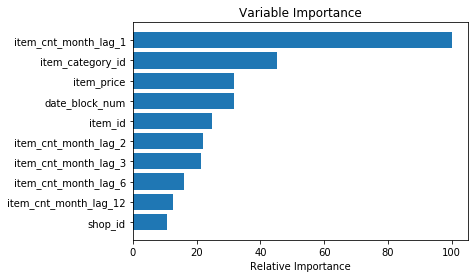

In [51]:
feature_importance = model3.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# LSTM

In [270]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#create 3 dimentional vectors for a single column
def Create_feature(store_num,column_value,agg_way):    
    dt_small=dt[dt["shop_id"]<store_num]
    dataset = dt_small.pivot_table(index = ['shop_id','item_id'],
                                   values = [column_value],
                                   columns = ["date_block_num"],
                                   fill_value = 0,aggfunc=agg_way)
    dataset.reset_index(inplace = True)
    test_data=dt2[(dt2["date_block_num"]==33) & (dt2["shop_id"]<store_num)][['item_id','shop_id']]
    dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')
    dataset.fillna(0,inplace = True)
    dataset.drop(['shop_id','item_id'],inplace = True, axis = 1)
    a = np.expand_dims(dataset.values[:,:-1],axis = 2)
    b = dataset.values[:,-1:]
    return a,b

# get feature 1
X_f1,y_f1=Create_feature(12,"item_cnt_day","sum")
#X_f1=X_f1.reshape(X_f1.shape[0], X_f1.shape[1])
#scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))
#X_f1 = scaler.fit_transform(X_f1)
#X_f1=np.expand_dims(X_f1,axis = 2)
print(X_f1.shape,y_f1.shape)
# get feature 2
X_f2,y_f2=Create_feature(12,"item_price","mean")
X_f2=X_f2.reshape(X_f2.shape[0], X_f2.shape[1])
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_f2 = scaler.fit_transform(X_f2)
X_f2=np.expand_dims(X_f2,axis = 2)
print(X_f2.shape,y_f2.shape)
#conbine two features
X_train_LSTM_all = np.append(X_f1,X_f2,axis=2)
print("X_train_LSTM_all Predictor Shape: ",X_train_LSTM_all.shape)
y_train_LSTM=y_f1
print("y_train_LSTM Predictor Shape: ",y_train_LSTM.shape)

Using TensorFlow backend.
/Users/jason/Documents/Software/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jason/Documents/Software/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jason/Documents/Software/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

(4198, 33, 1) (4198, 1)
(4198, 33, 1) (4198, 1)
X_train_LSTM_all Predictor Shape:  (4198, 33, 2)
y_train_LSTM Predictor Shape:  (4198, 1)


In [271]:
# our defining our model 
model2 = Sequential()
model2.add(LSTM(units = 64,input_shape = (X_train_LSTM_all.shape[1],X_train_LSTM_all.shape[2])))
model2.add(Dropout(0.4))
model2.add(Dense(1))
model2.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [272]:
%%time
model2.fit(X_train_LSTM_all,y_train_LSTM,batch_size = 128,epochs = 3) 


Epoch 1/3
4198/4198 [==============================] - 7s 2ms/step - loss: 40.1088 - mean_squared_error: 40.1088
Epoch 2/3
4198/4198 [==============================] - 5s 1ms/step - loss: 38.3266 - mean_squared_error: 38.3266
Epoch 3/3
4198/4198 [==============================] - 5s 1ms/step - loss: 38.0517 - mean_squared_error: 38.0517
CPU times: user 39 s, sys: 1.57 s, total: 40.6 s
Wall time: 17.6 s


# LSTM-TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model

#create 3 dimentional vectors for a single column
def Create_feature(store_num,column_value,agg_way):    
    dt_small=dt[dt["shop_id"]<store_num]
    dataset = dt_small.pivot_table(index = ['shop_id','item_id'],
                                   values = [column_value],
                                   columns = ["date_block_num"],
                                   fill_value = 0,aggfunc=agg_way)
    dataset.reset_index(inplace = True)
    test_data=dt2[(dt2["date_block_num"]==33) & (dt2["shop_id"]<store_num)][['item_id','shop_id']]
    dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')
    dataset.fillna(0,inplace = True)
    dataset.drop(['shop_id','item_id'],inplace = True, axis = 1)
    a = np.expand_dims(dataset.values[:,:-1],axis = 2)
    b = dataset.values[:,-1:]
    return a,b

# get feature 1
X_f1,y_f1=Create_feature(9,"item_cnt_day","sum")
#X_f1=X_f1.reshape(X_f1.shape[0], X_f1.shape[1])
#scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))
#X_f1 = scaler.fit_transform(X_f1)
#X_f1=np.expand_dims(X_f1,axis = 2)
print(X_f1.shape,y_f1.shape)
# get feature 2
X_f2,y_f2=Create_feature(9,"item_price","mean")
X_f2=X_f2.reshape(X_f2.shape[0], X_f2.shape[1])
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_f2 = scaler.fit_transform(X_f2)
X_f2=np.expand_dims(X_f2,axis = 2)
print(X_f2.shape,y_f2.shape)
#conbine two features
X_train_LSTM_all = np.append(X_f1,X_f2,axis=2)
print("X_train_LSTM_all Predictor Shape: ",X_train_LSTM_all.shape)
y_train_LSTM=y_f1
print("y_train_LSTM Predictor Shape: ",y_train_LSTM.shape)

In [ ]:
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.LSTM(128,input_shape=(X_train_LSTM_all.shape[1],X_train_LSTM_all.shape[2])))
model4.add(tf.keras.layers.Dropout(0.4))
model4.add(tf.keras.layers.Dense(1,activation='relu'))
model4.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'mse', metrics = ['mean_squared_error'])
model4.summary()

In [ ]:
%%time
model4.fit(X_train_LSTM_all,y_train_LSTM,batch_size = 128,epochs = 3) 